## Imports

In [16]:
from utils import vmt_utils
from utils import regression
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import numpy as np
import nibabel as nib
import h5py
import cPickle

In [17]:
%matplotlib inline

In [18]:
def load_data(filename):
    """ Return fMRI data corresponding to the given filename and prints
        shape of the data array
    ----------
    filename : string 
        This string should be a path to given file. The file must be
        .nii 
    Returns
    -------
    data : numpy array
        An array consisting of the data. 
    """
    img = nib.load(filename)
    data = img.get_data()
    data = data[:,:,:,4:]
    print(data.shape)
    return data

def combine_run_arrays(run_array_lst):
    """ Returns a combined 4d array by concatinating based on time (axis = 3)
    ----------
    run_array_lst : array of 4d numpy arrays 

    Returns
    -------
    4d numpy array 
    """
    return np.concatenate(run_array_lst, axis = 3)

## Get data

In [201]:
#All file strings corresponding to BOLD data for subject 4 
files = ['task001_run001.bold_dico.nii', 'task001_run002.bold_dico.nii', 
         'task001_run003.bold_dico.nii', 'task001_run004.bold_dico.nii', 
         'task001_run005.bold_dico.nii', 'task001_run006.bold_dico.nii',
         'task001_run007.bold_dico.nii', 'task001_run008.bold_dico.nii']

all_data = []
for index, filename in enumerate(files):
    new_data = load_data('../../data/' + filename) #load_data function drops first 4 for us
    num_vols = new_data.shape[-1]
    if index != 0 and index != 7:
        new_num_vols = num_vols - 4   
        new_data = new_data[:,:,:,:new_num_vols] #Drop last 4 volumes for middle runs    
    print(new_data.shape[-1])
    all_data.append(new_data)

combined_runs = combine_run_arrays(all_data) 
# combined_runs = combined_runs[:,:,:,9:] #First 17 seconds are credits/no scene id so drop

(160, 160, 36, 447)
447
(160, 160, 36, 437)
433
(160, 160, 36, 434)
430
(160, 160, 36, 484)
480
(160, 160, 36, 458)
454
(160, 160, 36, 435)
431
(160, 160, 36, 538)
534
(160, 160, 36, 259)
259


In [202]:
combined_runs.shape

(160, 160, 36, 3468)

## Get feature space

In [19]:
# Get stimulus feature spaces
stim_fs_fpath = '../description_pp/design_matrix_1.npy'
stim_fs_file = np.load(stim_fs_fpath)
stim_fs_file = stim_fs_file[0:3468,:]

In [20]:
stim_fs_file.shape

(3468, 1155)

## Separate Trainig and testing data

In [21]:
e, v = 3000, 468

In [22]:
stim_fs_est = stim_fs_file[:e,:]
stim_fs_val = stim_fs_file[:v,:]

In [23]:
print('Estimation feature space shape: %s'%repr(stim_fs_est.shape))
print('Validation feature space shape: %s'%repr(stim_fs_val.shape))

Estimation feature space shape: (3000, 1155)
Validation feature space shape: (468, 1155)


In [10]:
data_est = combined_runs[...,:e]
data_val = combined_runs[...,:v]

In [12]:
print('Estimation data shape: %s'%repr(data_est.shape))
print('Validation data shape: %s'%repr(data_val.shape))

Estimation data shape: (160, 160, 36, 3000)
Validation data shape: (160, 160, 36, 468)


## compute variance of data and generate mask

In [16]:
dv = data_val.reshape((160*160*36, 468))

In [42]:
vdv = np.var(dv,axis=1)

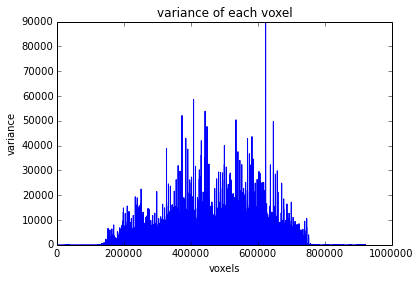

In [48]:
plt.plot(vdv)
plt.title('variance of each voxel')
plt.ylabel('variance')
plt.xlabel('voxels')

In [57]:
mask1000 = vdv>1000
print sum(mask1000)
np.save('../brain_mask/mask34589.npy',mask1000)

34589


In [58]:
mask5000 = vdv>5000
print sum(mask5000)
np.save('../brain_mask/mask3087.npy',mask5000)

3087


In [59]:
mask3000 = vdv>3000
print sum(mask3000)
np.save('../brain_mask/mask6810.npy',mask3000)

6810


## Mask fMRI data

In [24]:
#load mask
mask_f =  np.load('../brain_mask/mask34589.npy')

In [25]:
mask = mask_f.reshape((36,160,160))

In [ ]:
dvm = dv[mask_f,:]

In [52]:
dvm.shape

(34589, 468)

In [51]:
np.save('../data/BOLD_val_masked34589.npy',dvm)

In [42]:
data_est_masked = None
for i in range(10):
    print i
    de1 = data_est[:,:,:,i*300:(i+1)*300].reshape((160*160*36, 300))
    de1_masked = de1[mask,:]
    if data_est_masked is None:
        data_est_masked = de1_masked
    data_est_masked = np.hstack((data_est_masked,de1_masked))

0
1
2
3
4
5
6
7
8
9


In [44]:
dem = data_est_masked[:,300:]

In [53]:
dem.shape

(34589, 3000)

In [46]:
np.save('../data/BOLD_est_masked34589.npy',dem)

In [23]:
#a = np.array([[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11,12]]])

In [ ]:
data_est_masked =  dem.T
data_val_masked =  dvm.T
# Show size of masked data
print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
print('Size of masked validation data is %s'%repr(data_val_masked.shape))

In [14]:
# print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
# print('Size of masked validation data is %s'%repr(data_val_masked.shape))

Size of masked estimation data is (1200, 58108)
Size of masked validation data is (90, 58108)


##Set up feature space matrix to do regression

In [ ]:
# Create lagged stimulus matrix
efs = vmt_utils.add_lags(stim_fs_est,[2,3,4])
vfs = vmt_utils.add_lags(stim_fs_val,[2,3,4])
# Add column of ones
efs = vmt_utils.add_constant(efs,is_first=True)
vfs = vmt_utils.add_constant(vfs,is_first=True)

In [189]:
efs_subset = efs[:1200,:]
vfs_subset = vfs[:90,:]
print efs.shape
print vfs.shape
print efs_subset.shape
print vfs_subset.shape

(3000, 3466)
(468, 3466)
(1200, 3466)
(90, 3466)


## Load masked data


In [27]:
data_est_masked = np.load('../data/BOLD_est_masked34589.npy').T[:1200,:]
data_val_masked_subset = np.load('../data/BOLD_val_masked34589.npy').T[:90,:]
data_val_masked = np.load('../data/BOLD_val_masked34589.npy').T
print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
print('Size of masked validation data is %s'%repr(data_val_masked.shape))

IOError: [Errno 2] No such file or directory: '../../data/BOLD_est_masked34589.npy'

## Run regression

In [83]:
alpha = np.logspace(0,6,10)
alpha

array([  1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
         1.00000000e+02,   4.64158883e+02,   2.15443469e+03,
         1.00000000e+04,   4.64158883e+04,   2.15443469e+05,
         1.00000000e+06])

In [84]:
# Run regression 
n_splits = 10 # number of subdivisions of validation data for cross validation of ridge parameter (alpha)
n_resamps = 10 # number of times to compute regression & prediction within training data (can be <= n_splits)
chunk_sz = 6000 # number of voxels to fit at once. Memory-saving.
pthr = 0.005 # Ridge parameter is chosen based on how many voxels are predicted above a correlation threshold 
             # for each alpha value (technically it's slightly more complicated than that, see the code). 
             # This p value sets that correlation threshold.
t0 = time.time()

out = regression.ridge_cv(efs,data_est_masked,val_fs=vfs,val_data=data_val_masked,alphas=alpha,n_resamps=n_resamps,
                              n_splits=n_splits,chunk_sz=chunk_sz,pthr=pthr,is_verbose=True)

t1 = time.time()
print("Elapsed time is: %d min, %d sec"%((t1-t0)/60,(t1-t0)%60))

Running split 1/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 2/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 3/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 4/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 5/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chunk 6 of 6...

Running split 6/10
Running chunk 1 of 6...

Running chunk 2 of 6...

Running chunk 3 of 6...

Running chunk 4 of 6...

Running chunk 5 of 6...

Running chu

In [53]:
vmt.regression.ridge_cv?

##Make sure estimation procedure chose a reasonable $\alpha$ value
There should be a somewhat obvious maximum in the curve plotted below

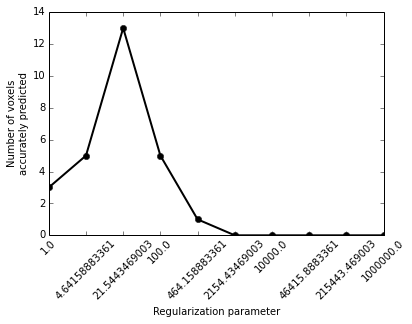

In [85]:
# Plot number of voxels with significant prediction accuracy within the 
# estimation data for each alpha value
na = len(out['n_sig_vox_byalpha'])
plt.plot(range(na),out['n_sig_vox_byalpha'],'ko-',lw=2)
# plt.xticks(range(na),vmt.regression.DEFAULT_ALPHAS,rotation=45)
plt.xticks(range(na),alpha,rotation=45)
plt.xlabel('Regularization parameter')
_ = plt.ylabel('Number of voxels\naccurately predicted')

##Display prediction accuracy results on the cortical surface

In [86]:
out['cc'].shape

(34589,)

In [95]:
cc = out['cc']

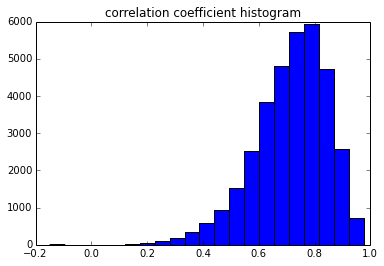

In [96]:
plt.hist(np.nan_to_num(out['cc']),21)
plt.title('correlation coefficient histogram')

In [186]:
weights.shape

(3466, 34589)

In [191]:
voxel_idx = np.argsort(cc)[::-1][:100]

34274
1
1
34380
1
2
496
2
1
6625
2
2


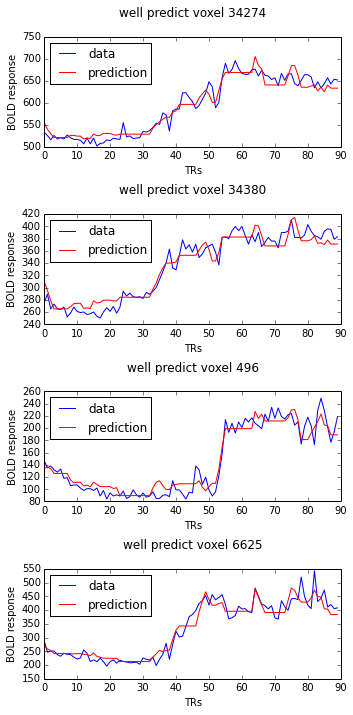

In [200]:
plt.figure(figsize=(5,10))
for n in range(4):
    i = voxel_idx[n+10]
    print i
    print n//2+1
    print n%2+1
    pred_activity = vfs_subset.dot(weights[:,i])
    plt.subplot(4,n//4+1,n%4+1)
    l1, = plt.plot(data_val_masked_subset[:,i],'b')
    l2, = plt.plot(pred_activity,'r')
    plt.ylabel('BOLD response')
    plt.xlabel('TRs')
    plt.title('well predict voxel %d\n'%i)
    plt.legend([l1, l2], ['data','prediction'],loc=2)
    
plt.tight_layout()

In [197]:
data_est_masked.shape

(1200, 34589)

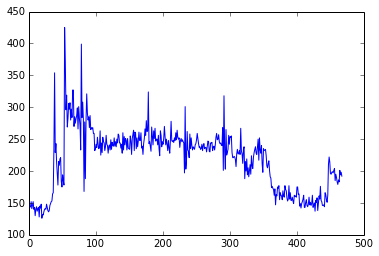

In [199]:
plt.plot(data_val_masked[:,1000])

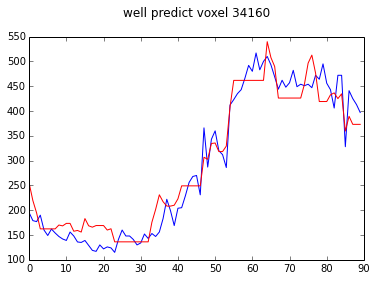

In [142]:
plot

In [127]:
sum(cc>0.6)

28432

In [90]:
# output the regression output
output_fpath = '../../data/regression_output.hdf5'

In [97]:
with h5py.File(output_fpath,'w') as f:
    brDset = f.create_dataset('br', br.shape, br.dtype)
    brDset[:] = br
    
    ccDset = f.create_dataset('cc', cc.shape, cc.dtype)
    ccDset[:] = cc

    weightsDset = f.create_dataset('weights',out['weights'].shape, out['weights'].dtype)
    weightsDset[:] = out['weights']

In [98]:
out.keys()

['cc', 'alpha', 'n_sig_vox_byalpha', 'weights']

In [77]:
# input the regression output in the case of firefox crash
with h5py.File(output_fpath,'r') as hf:
    br = hf['br'].value
    weights = hf['weights'].value
    cc = hf['cc'].value

In [15]:
np.nanmin(br)

-0.14837539196014404

In [16]:
np.nanmax(br)

0.97725570201873779

In [18]:
# load all the nouns in movie labels
word_list_path = '../description_pp/word_list.p'
f = file(word_list_path, 'rb')
word_list = cPickle.load(f)
f.close()

In [19]:
len(word_list)

1155